In [1]:
import os
import torch
import numbers
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from diffusers import DDIMPipeline


In [2]:
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1)
    return a.item()

def to_image(img_tensor):
    img = (255*(img_tensor + 1)/2).permute(1, 2, 0).detach().cpu().numpy()
    img = img.clip(0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def diffusion_step(img, model, t, alpha, alpha_next):
    ts = torch.full((b,), t, device=device, dtype=torch.long)
    model.eval()
    e_t = model(img, ts).sample

    a_t = torch.full((b, 1, 1, 1), alpha, device=device)
    a_next = torch.full((b, 1, 1, 1), alpha_next, device=device)
    sqrt_one_minus_at = (1 - a_t).sqrt()

    # current prediction for x_0
    pred_x0 = (img - sqrt_one_minus_at * e_t) / a_t.sqrt()

    # direction pointing to x_t
    dir_xt = (1. - a_next).sqrt() * e_t
    x_prev = a_next.sqrt() * pred_x0 + dir_xt
    return x_prev


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# CIFAR10 Data

data_path = "~/workspace/compare-generative-models/data/"
test_transform = transforms.Compose(
            [transforms.Resize(32), transforms.ToTensor()]
        )
test_dataset = CIFAR10(
            data_path,
            train=False,
            download=True,
            transform=test_transform,
        )
test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=4,
        )

Files already downloaded and verified


In [5]:
# DDIM Setting

num_ddim_steps = 20
num_diffusion_timesteps = 1000
timesteps = torch.ceil(torch.linspace(0, num_diffusion_timesteps - 1, num_ddim_steps + 1)).long().to(device)


beta_start = 0.0001
beta_end = 0.02
betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
betas = torch.from_numpy(betas).float().to(device)

In [6]:
# Load Pretrained Model
model_id = "google/ddpm-cifar10-32"
# load model and scheduler
ddim = DDIMPipeline.from_pretrained(model_id)
model = ddim.unet

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/sun748/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/sun748/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


12 tensor([5])


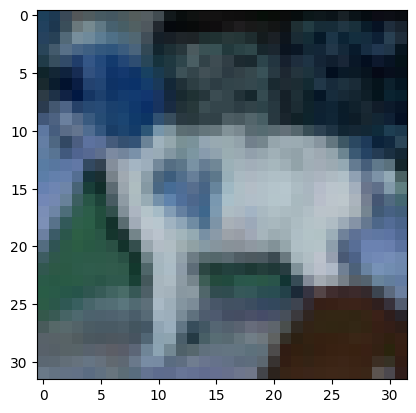

In [7]:
for i, (x, y) in enumerate(test_loader):
    # dog
    if y == 5:
        break

img = 2 * x - 1
print(i, y)
plt.imshow(to_image(img[0]))

In [8]:
x0 = img

b = x0.shape[0]
device = x0.device
log_every_t = 1


intermediates = [img]
time_range = timesteps
iterator = tqdm(time_range[0:-1], desc='DDIM Forward', total=num_ddim_steps)

DDIM Forward:   0%|                                                                                          | 0/20 [00:00<?, ?it/s]

In [9]:
for i, t in enumerate(iterator):
    alpha = compute_alpha(betas, time_range[i])
    alpha_next = compute_alpha(betas, time_range[i + 1])
    x_prev = diffusion_step(img, model, t, alpha, alpha_next)
    img = x_prev
    
    if i % log_every_t == 0 or i == num_ddim_steps - 1:
        intermediates.append(img)

DDIM Forward: 100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.75it/s]


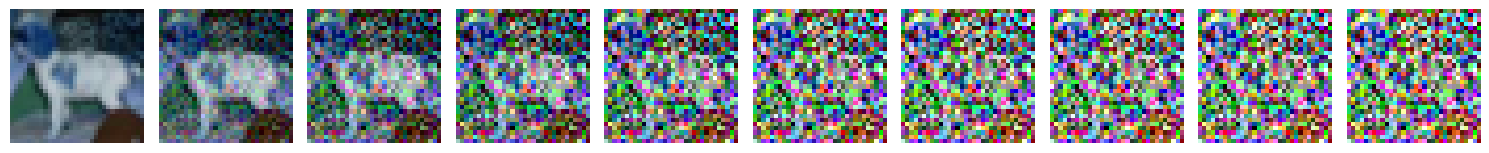

In [10]:
# Create a figure and axes to display images in a row
num_display = 10
fig, axes = plt.subplots(1, num_display, figsize=(15, 5))  
image_index = np.floor(np.linspace(0, len(intermediates) - 1, num_display)).astype(int)

for index, ax in enumerate(axes):
    ax.imshow(to_image(intermediates[image_index[index]][0]))                # Display the image
    ax.axis('off')                # Turn off axes for cleaner display
# Show the plot
plt.tight_layout()
plt.show()

In [11]:
xT = img

time_range_reverse = torch.flip(timesteps, [0])
iterator_reverse = tqdm(time_range_reverse[0:-1], desc='DDIM Backward', total=num_ddim_steps)
intermediates_reverse = [img]

DDIM Backward:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]

In [12]:
for i, t in enumerate(iterator_reverse):
    alpha = compute_alpha(betas, time_range_reverse[i])
    alpha_next = compute_alpha(betas, time_range_reverse[i + 1])
    x_prev = diffusion_step(img, model, t, alpha, alpha_next)
    img = x_prev
    
    if i % log_every_t == 0 or i == num_ddim_steps - 1:
        intermediates_reverse.append(img)

DDIM Backward: 100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]


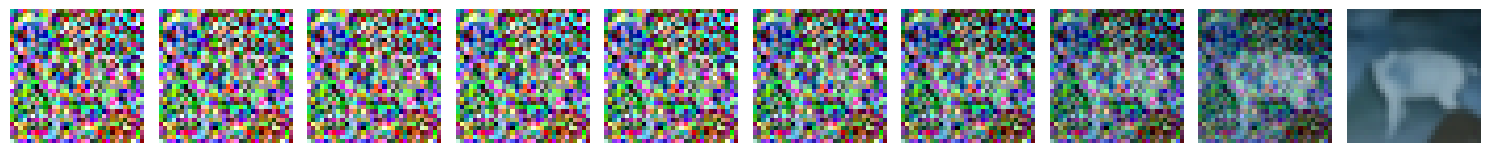

In [13]:
# Create a figure and axes to display images in a row
num_display = 10
fig, axes = plt.subplots(1, num_display, figsize=(15, 5))  
image_index = np.floor(np.linspace(0, len(intermediates_reverse) - 1, num_display)).astype(int)

for index, ax in enumerate(axes):
    ax.imshow(to_image(intermediates_reverse[image_index[index]][0]))                # Display the image
    ax.axis('off')                # Turn off axes for cleaner display
# Show the plot
plt.tight_layout()
plt.show()

In [14]:
# per pixel reconstruction error

(intermediates_reverse[-1][0] - x0[0]).pow(2).mean()

tensor(0.0250, grad_fn=<MeanBackward0>)